In [1]:
import time as t
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             ndcg_score, r2_score)
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
def create_regressor(vals):
    numeric_pipe = Pipeline(steps=[('imp_median', SimpleImputer(missing_values=np.nan, strategy='median')), ('scaler', StandardScaler())])
    preprocessor = ColumnTransformer(transformers=[('num', numeric_pipe, vals)])
    return preprocessor

def get_cat_feat_names(train_features):
    return list(train_features.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names(['division_winner', 'wildcard']))

def create_regress_categorical(cat_col, vals):
    categorical_features = cat_col
    numeric_features = vals
    
    categorical_transformer = Pipeline(
        steps=[
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ]
    )

    numeric_transformer = Pipeline(
        steps=[
            ('imp_median', SimpleImputer(missing_values=np.nan, strategy='median')), 
            ('scaler', StandardScaler())
        ]
    )
    preprocessor = ColumnTransformer(
        transformers=[
                ("num", numeric_transformer, numeric_features),
                ("cat", categorical_transformer, categorical_features),
            ]
    )
    
    clf = Pipeline(steps=[('preprocessor', preprocessor)])
    return clf

def get_feature_names(vals, cat_names):
    num_vals = vals.copy()
    for c in cat_names:
        num_vals.remove(c)
    return num_vals

In [3]:
df = pd.read_csv('2021_data.csv')
df.drop(columns=['year', 'Alias', 'Tm', 'team', 'W', 'L', 'W-L%'], inplace=True)

In [4]:
x_2020, y_2020 = df.drop(columns=['record']), df['record']

In [5]:
feature_names = list(x_2020.columns)
categorial_features = ['division_winner', 'wildcard']
numerical_features = get_feature_names(feature_names, categorial_features)
print(numerical_features, '-', categorial_features)

['PF', 'PA', 'PD', 'MoV', 'SoS', 'SRS', 'OSRS', 'DSRS', 'rank', 'counts'] - ['division_winner', 'wildcard']


In [6]:
rgs = create_regress_categorical(categorial_features, numerical_features)

In [8]:
train_features = rgs.fit(x_2020, df['record'])

In [9]:
x_tr = train_features.transform(x_2020)

In [10]:
clf = RandomForestRegressor(random_state=42)
clf.fit(x_tr, y_2020)

RandomForestRegressor(random_state=42)

In [11]:
import shap
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(rgs.fit_transform(x_2020))

/Users/magicpants/miniconda3/envs/tensorflow/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
cat_feats = list(train_features.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names(['division_winner', 'wildcard']))
all_feats = cat_feats + numerical_features
all_feats

['division_winner_False',
 'division_winner_True',
 'wildcard_False',
 'wildcard_True',
 'PF',
 'PA',
 'PD',
 'MoV',
 'SoS',
 'SRS',
 'OSRS',
 'DSRS',
 'rank',
 'counts']

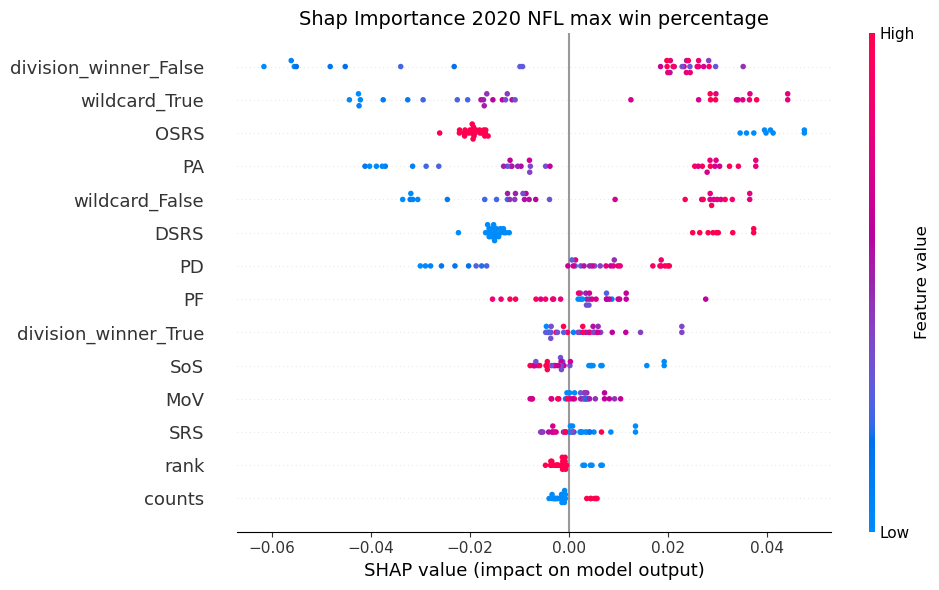

In [33]:
import matplotlib.pyplot as plt
shap.summary_plot(shap_values, x_tr, feature_names=all_feats, show=False, max_display=15, class_inds="original")
fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.title("Shap Importance 2020 NFL max win percentage", fontsize=14, loc="center")   
plt.tight_layout()
plt.show() 